# 核心模块 Core Module

> 主要定义与任务相关的核心组件和配置
> 
> Defines core components and configurations related to tasks

## 简介/Description: 

核心模块包含任务相关的主要类和配置文件，如 ClassificationTask 和 ClassificationTaskConfig。其中配置文件通过 Pydantic 进行定义，帮助用户更好地构建图像分类任务的各个部分。

The core module contains the primary classes and configuration files related to tasks, such as ClassificationTask and ClassificationTaskConfig, where the configurations are defined using Pydantic, allowing users to easily structure components of image classification tasks.

## 主要符号/Main symbols:

- ClassificationTask: 用于处理图像分类任务的 PyTorch Lightning 模块。
- ClassificationTask: A PyTorch Lightning module for handling image classification tasks.
- ClassificationTaskConfig: 使用 Pydantic 设计的配置类，用于初始化任务。
- ClassificationTaskConfig: A configuration class designed with Pydantic for initializing the task.


In [1]:
#| default_exp nucleus

In [2]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

In [3]:
#| export
import os
os.environ['HF_ENDPOINT'] = "https://hf-mirror.com" # TODO this is optional for Foreigners

In [4]:
from transformers import AutoModel, AutoConfig, ViTModel, ViTConfig
from namable_classify.infra import print_model_pretty
AutoModel.from_pretrained("google/vit-base-patch16-224-in21k").training

False

In [5]:
#| export
from pydantic import BaseModel
class ClassificationModelConfig(BaseModel):
    provider: str = "huggingface"
    checkpoint: str = "google/vit-base-patch16-224-in21k" # TODO 支持 hf  timm torch
    head_strategy: str = "linear"
    num_of_classes: int = -1
    
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from transformers import AutoModel, AutoConfig, ViTModel, ViTConfig
from transformers import AutoImageProcessor, BitImageProcessor, ViTImageProcessor
from deepspeed.ops.adam import DeepSpeedCPUAdam

class HuggingfaceModel(nn.Module):
    """Some Information about HuggingfaceModel"""
    def __init__(self, config : ClassificationModelConfig, forward_with_hf_image_preprocessor=False):
        super().__init__()
        # self.image_preprocessor = BitImageProcessor.from_pretrained(config.model_checkpoint, use_fast=True)
        self.image_preprocessor = AutoImageProcessor.from_pretrained(config.checkpoint)
        self.backbone: ViTModel = AutoModel.from_pretrained(config.checkpoint) # TODO we now just consider ViTModel
        self.backbone.train()
        self.backbone_config: ViTConfig = self.backbone.config # 包括了 image_size 和 hidden_size 这两个重要信息
        if config.head_strategy == "linear":
            self.head = nn.Linear(self.backbone_config.hidden_size, config.num_of_classes)
        else:
            raise NotImplementedError("Only linear head is supported for now. ")
        self.config = config
        self.forward_with_hf_image_preprocessor = forward_with_hf_image_preprocessor
        # 虽然huggingface的dummy inputs很多都是假的不是真的能测试这个模型，但是OpenDelta很矫情，还是认为要有。
        self.dummy_inputs = self.backbone.dummy_inputs
        
    
    
    
    def forward(self, x:torch.Tensor)->torch.Tensor:
        if self.forward_with_hf_image_preprocessor:
            x = self.image_preprocessor(images=x, return_tensors="pt")["pixel_values"]
        hf_output = self.backbone(x)
        # hidden_state = hf_output.last_hidden_state
        output = hf_output.pooler_output
        output = self.head(output)
        return output
    
from fastcore.basics import patch
@patch
def get_cls_model(self:ClassificationModelConfig):
    if self.provider == "huggingface":
        return HuggingfaceModel(self)
    else:
        raise NotImplementedError("Only huggingface is supported for now. ")

In [6]:
#| export
import lightning as L
from pydantic import BaseModel
from namable_classify.data import ClassificationDataConfig, ClassificationDataModule

class ClassificationTaskConfig(BaseModel):
    experiment_project: str = "NamableClassify Development" # 为了发表什么论文，正在探索什么IDEA？
    experiment_task: str = "Development Test" # 为了证明我的IDEA有效，正在做哪个数据集、哪个架构的实验？
    experiment_index: int = 0  # [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 表示是第几次重复实验 # which is also the random seed
    label_smoothing: float = 0.1
    cls_model_config: ClassificationModelConfig = ClassificationModelConfig()
    dataset_config: ClassificationDataConfig = ClassificationDataConfig()
    learning_rate: float = 3e-4
    yuequ:str = "full_finetune"
    yuequ_pe:float = 0.0

In [7]:
#| export
@patch
def see_params_norm(self:nn.Module)->float:
    params = torch.cat([param.view(-1) for param in self.parameters()])
    # 计算范数，这里以2-范数为例
    norm = torch.norm(params, p=2)
    return norm.item()

@patch
def see_grad_norm(self:nn.Module)-> float:
    grads = torch.cat([param.grad.view(-1) for param in self.parameters() if param.grad is not None])
    # 计算范数，这里以2-范数为例
    norm = torch.norm(grads, p=2)
    return norm.item()
    

In [6]:
#| export
from lightning.pytorch import loggers as pl_loggers
from namable_classify.help import runs_path

In [9]:
logger = pl_loggers.TensorBoardLogger(runs_path/"test")
logger.experiment # .experiment 得到的是第三方平台的类型。
# dir(logger) # pl的logger类型方法少很多

In [ ]:
#| export
import lightning as L
from lightning.pytorch.utilities.types import EVAL_DATALOADERS, TRAIN_DATALOADERS, STEP_OUTPUT, OptimizerLRScheduler
from overrides import override
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from deepspeed.ops.adam import DeepSpeedCPUAdam, FusedAdam 
from deepspeed.ops.lamb import FusedLamb

from namable_classify.infra import print_model_pretty
from namable_classify.infra import append_dict_list, ensure_array, logger
from namable_classify.metrics import compute_classification_metrics, draw_classification_metrics
import numpy as np
from typing import Any, Optional
class ClassificationTask(L.LightningModule):
    def __init__(self, config: ClassificationTaskConfig)->None:
        super().__init__()
        self.save_hyperparameters(config.model_dump())
        L.seed_everything(config.experiment_index) # use index as the seed for reproducibility
        # 首先数据是可以加载的
        self.lit_data:ClassificationDataModule = config.dataset_config.get_lightning_data_module()
        # 数据怎么做Transform，取决于 Model的情况
        # 现在我们加载Model，刚才有了数据之后，首先可以更新 cls_model_config
        
        config.cls_model_config.num_of_classes = self.lit_data.num_of_classes
        self.cls_model:HuggingfaceModel = config.cls_model_config.get_cls_model()
        
        # 现在需要更新数据
        model_image_size:tuple[int, int] = self.lit_data.set_transform_from_hf_image_preprocessor(hf_image_preprocessor=self.cls_model.image_preprocessor)
        
        # model_image_size:tuple[int, int] = (self.cls_model.image_preprocessor.size['height'], self.cls_model.image_preprocessor.size['width'])
        self.example_input_array = torch.randn((1, self.cls_model.backbone.config.num_channels, 
                                                *model_image_size), requires_grad=True)
        self.dummy_inputs = dict(input_ids=self.example_input_array) # for opendelta and huggingface
        # self.dummy_inputs_is_correct = True # Used for boguan_yuequ (博观约取) 's auto opendelta 
        # 最后是训练策略
        # self.softmax = nn.Softmax(dim=1)    
        self.softmax = nn.Identity()
        self.loss = nn.CrossEntropyLoss(label_smoothing=config.label_smoothing)
        # nn.LogSoftmax(dim=1)
        # https://blog.csdn.net/qq_43391414/article/details/118421352 logsoftmax+nll的速度快，但是没有label smoothing
        
        # 评价策略
        self.evaluation_steps_outputs = dict()
        
        # self.automatic_optimization = False
        self.automatic_optimization = True
        
        # 上面初始化后config有变化，所以需要重新保存一下。
        self.save_hyperparameters(config.model_dump())
        
        # 之前的loss
        self.previous_loss:Optional[float] = None
    
    # @override
    # def on_train_start(self) -> None:
    #     # 更新一下最终的超参数
    #     # self.save_hyperparameters(self.hparams)
    #     # self.lit_data.save_hyperparameters(self.lit_data.hparams)
    #     return super().on_train_start()
    
    def compute_model_logits(self, image_tensor:torch.Tensor)-> torch.Tensor:
        return self.cls_model(image_tensor)
    
    @override
    def forward(self, image_tensor:torch.Tensor, *args, **kwargs)-> torch.Tensor:
        return self.softmax(self.compute_model_logits(image_tensor))

    def forward_loss(self, image_tensor: torch.Tensor, label_tensor:torch.Tensor)->torch.Tensor:
        probs = self(image_tensor)
        # return F.nll_loss(logits, label_tensor)
        return self.loss(probs, label_tensor)

    @override
    def training_step(self, batch, batch_idx=None, *args, **kwargs)-> STEP_OUTPUT:
        # self.train() # 不必要
        # opt = self.optimizers(use_pl_optimizer=False)
        # opt = self.optimizers(use_pl_optimizer=True)
        # opt.zero_grad()
        
        loss = self.forward_loss(*batch)
        self.log("train_loss", loss, prog_bar=True)
        if self.previous_loss is not None:
            self.log("train_loss_delta", float(loss) - self.previous_loss, prog_bar=True)
        self.previous_loss = float(loss)
        # print("Loss:", loss.item())
        # self.manual_backward(loss)
        # loss.backward()
        # self.log("grad_norm", self.see_grad_norm(), prog_bar=True)
        # old_params_norm = self.see_params_norm()
        
        # self.log("params_norm", old_params_norm, prog_bar=True)
        
        # # print("Grad Norm:", self.see_grad_norm())
        # # print("Params Norm before step:", self.see_params_norm())
        # # print("Params of cls_model Norm before step:", self.cls_model.see_params_norm())
        # opt.step()
        # # print("Params Norm after step:", self.see_params_norm())
        # # print("Params of cls_model Norm after step:", self.cls_model.see_params_norm())
        # params_norm_delta = self.see_params_norm() - old_params_norm
        # self.log("params_norm_delta", params_norm_delta, prog_bar=True)
        
        
        
        # sch = self.lr_schedulers()
        # self.log("lr", sch.get_last_lr()[0], prog_bar=True)
        # # https://www.restack.io/p/pytorch-lightning-answer-get-current-training-step-cat-ai
        # # https://github.com/Lightning-AI/pytorch-lightning/pull/11599
        # sch.step(self.global_step/self.trainer.estimated_stepping_batches/self.trainer.max_epochs)
        
        # self.log("global_step", self.global_step, prog_bar=True)
        # # self.log("epoch", self.current_epoch, prog_bar=True)
        # self.log("stepping_batches_of_one_epoch", self.trainer.estimated_stepping_batches/self.trainer.max_epochs, prog_bar=True)
        
        # print()
        # print(loss)
        return loss


    @override    
    def configure_optimizers(self) -> OptimizerLRScheduler:
        # return torch.optim.SGD(self.parameters(), lr=self.hparams.learning_rate)
        # return torch.optim.SGD(self.cls_model.parameters(), lr=self.hparams.learning_rate)
        # print("Learning Rate:", self.hparams.learning_rate)
        # return torch.optim.AdamW(self.parameters(), lr=self.hparams.learning_rate)
        # return torch.optim.AdamW(self.cls_model.parameters(), lr=self.hparams.learning_rate)
        
        # optimizer = optim.SGD(self.cls_model.parameters(), lr=self.hparams.learning_rate)
        # print(len(list(self.parameters())))
        
        # optimizer = optim.AdamW(self.parameters(), lr=self.hparams.learning_rate)
        # optimizer = FusedLamb(self.parameters(), lr=self.hparams.learning_rate)
        optimizer = DeepSpeedCPUAdam(self.parameters(), lr=self.hparams.learning_rate)
        # scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=self.hparams.learning_rate/10, 
        #                                               max_lr=self.hparams.learning_rate)
        # https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingWarmRestarts.html
        # https://www.kaggle.com/code/isbhargav/guide-to-pytorch-learning-rate-scheduling#9.CosineAnnealingWarmRestarts
        # scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
        # return ([optimizer], [scheduler])
        return optimizer
        # return ([optimizer], [{"scheduler": scheduler, "interval": "step"}])
        # return L.AdamW(self.parameters(), lr=self.learning_rate)

    # 现在我们已经定义好Training的逻辑了，已经可以跑训练了。然而，除了训练之外，我们需要评测模型的性能。
    # @override
    # def 
    def on_evaluation_epoch_start(self, stage:str=""):
        self.evaluation_steps_outputs = dict()
        self.evaluation_steps_outputs[f'{stage}_batch_probs'] = []
        self.evaluation_steps_outputs[f'{stage}_label_tensor'] = []
            
    def evaluation_step(self, batch, batch_idx=None, stage:str="", *args: Any, **kwargs: Any) -> STEP_OUTPUT:
        image_tensor, label_tensor = batch
        batch_probs = self(image_tensor)
        append_dict_list(self.evaluation_steps_outputs, f'{stage}_batch_probs', ensure_array(batch_probs))
        append_dict_list(self.evaluation_steps_outputs, f'{stage}_label_tensor', ensure_array(label_tensor))
        batch_loss = self.loss(batch_probs, label_tensor)
        self.log(f"{stage}_loss", batch_loss, prog_bar=True)
        return batch_loss
            
    def on_evaluation_epoch_end(self, stage:str=""):
        # https://github.com/Lightning-AI/pytorch-lightning/discussions/9845
        # labels = self.lit_data.classes
        labels = list(range(self.lit_data.num_of_classes))
        # labels = None
        # print(labels)
        # stack 是 new axis， concat是existing axis
        all_pred_probs = np.concatenate(self.evaluation_steps_outputs[f'{stage}_batch_probs'])
        all_label_tensor = np.concatenate(self.evaluation_steps_outputs[f'{stage}_label_tensor'])
        # logger.debug(self.evaluation_steps_outputs[f'{stage}_label_tensor'])
        # logger.debug(all_label_tensor)
        eval_dict = compute_classification_metrics(all_label_tensor, all_pred_probs, 
                                                #    logits_to_prob=False, 
                                                   logits_to_prob=True, 
                                                labels=labels)
        eval_dict = {f"{stage}_{k}": v for k,v in eval_dict.items()}
        self.log_dict(eval_dict)
        # tensorboard 可视化
        # draw_classification_metrics
        figures, figure_names = draw_classification_metrics(all_label_tensor, all_pred_probs, 
                                              logits_to_prob=True, 
                                                labels=labels)
        # TODO: bug
        # tb_logger = self.get_logger_with_type(pl_loggers.TensorBoardLogger).experiment
        tb_logger = self.trainer.loggers[0].experiment
        for fig, name in zip(figures, figure_names):
            tb_logger.add_figure(f"{stage}/{name}", fig, self.global_step)
        # tb_logger.add_pr_curve(f"{stage}/pr_curve", all_label_tensor, all_pred_probs, self.global_step)
        
        
        self.evaluation_steps_outputs.clear()
        
    def get_logger_with_type(self, t:type = pl_loggers.TensorBoardLogger)->pl_loggers.Logger:
        # Get tensorboard logger
        target_logger = None
        for logger in self.trainer.loggers:
            if isinstance(logger, t):
                target_logger = logger
                break
        return target_logger

    @override
    def on_validation_epoch_start(self):
        return self.on_evaluation_epoch_start(stage="val")
    
    @override
    def on_test_epoch_start(self):
        return self.on_evaluation_epoch_start(stage="test")

    @override
    def on_validation_epoch_end(self):
        return self.on_evaluation_epoch_end(stage="val")

    @override
    def on_test_epoch_end(self):
        return self.on_evaluation_epoch_end(stage="test")

    @override
    def validation_step(self, batch, batch_idx=None, *args, **kwargs):
        return self.evaluation_step(batch, batch_idx, stage="val")

    @override
    def test_step(self, batch, batch_idx=None, *args, **kwargs):
        return self.evaluation_step(batch, batch_idx, stage="test")


In [9]:
config = ClassificationTaskConfig(
    # learning_rate=1e-3,
    learning_rate=3e-4,
    # learning_rate=1,
    # learning_rate=1e9,
    label_smoothing=0,
)
config
cls_task = ClassificationTask(config)
cls_task.print_model_pretty()
cls_task.print_trainable_parameters()

INFO: Seed set to 0


Thu 2024-11-28 17:44:43.671493

INFO     Seed set to 0                                                                                   ]8;id=32847;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/fabric/utilities/seed.py\seed.py]8;;\:]8;id=585575;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/fabric/utilities/seed.py#57\57]8;;\

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
/home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Thu 2024-11-28 17:44:45.209294

INFO     ╭──────────────────────────── Model Tree for ClassificationTask ─────────────────────────────╮ ]8;id=271493;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/torch.py\torch.py]8;;\:]8;id=536110;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/torch.py#72\72]8;;\
         │ root                                                                                       │            
         │ └── cls_model (HuggingfaceModel)                                                           │            
         │     ├── backbone (ViTModel)                                                                │            
         │     │   ├── embeddings (ViTEmbeddings) cls_token:[1, 1, 768] position_embeddings:[1, 197,  │            
         │     │   │   768]                                                                           │            
         │     │   │   └── patch_embeddings (ViTPatchEmbeddings)                                      │            
         │     │   │       └── projection (Conv2d) weight:[768, 3, 16, 16] bias:[768]                 │            
         │     │   ├── encoder (ViTEncoder)                                                           │            
         │     │   │   └── layer (ModuleList)                                                         │            
         │     │   │       └── 0-11(ViTLayer)                                                         │            
         │     │   │           ├── attention (ViTSdpaAttention)                                       │            
         │     │   │           │   ├── attention (ViTSdpaSelfAttention)                               │            
         │     │   │           │   │   └── query,key,value(Linear) weight:[768, 768] bias:[768]       │            
         │     │   │           │   └── output (ViTSelfOutput)                                         │            
         │     │   │           │       └── dense (Linear) weight:[768, 768] bias:[768]                │            
         │     │   │           ├── intermediate (ViTIntermediate)                                     │            
         │     │   │           │   └── dense (Linear) weight:[3072, 768] bias:[3072]                  │            
         │     │   │           ├── output (ViTOutput)                                                 │            
         │     │   │           │   └── dense (Linear) weight:[768, 3072] bias:[768]                   │            
         │     │   │           └── layernorm_before,layernorm_after(LayerNorm) weight:[768]           │            
         │     │   │               bias:[768]                                                         │            
         │     │   ├── layernorm (LayerNorm) weight:[768] bias:[768]                                  │            
         │     │   └── pooler (ViTPooler)                                                             │            
         │     │       └── dense (Linear) weight:[768, 768] bias:[768]                                │            
         │     └── head (Linear) weight:[100, 768] bias:[100]                                         │            
         ╰────────────────────────────────────────────────────────────────────────────────────────────╯            

Thu 2024-11-28 17:44:45.342225

INFO                    Model ClassificationTask's Trainable Parameters Inspection                      ]8;id=318046;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/torch.py\torch.py]8;;\:]8;id=499748;file:///home/ye_canming/repos/novelties/cv/ScholarlyInfrastructure/scholarly_infrastructure/logging/torch.py#55\55]8;;\
         ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓                  
         ┃ Number of Trainable Parameters ┃ Number of Total Parameters  ┃ Trainable Ratio (0-1) ┃                  
         ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩                  
         │    8.647e+07 (3.459e+08 bytes) │ 8.647e+07 (3.459e+08 bytes) │             1.000e+00 │                  
         └────────────────────────────────┴─────────────────────────────┴───────────────────────┘                  

In [10]:
#| eval: false
trainer = L.Trainer()
from lightning.pytorch.tuner import Tuner
tuner = Tuner(trainer)
found_batch_size = tuner.scale_batch_size(cls_task, datamodule=cls_task.lit_data, 
                                          mode='binsearch', 
                                          init_val=64)
found_batch_size, cls_task.lit_data.hparams.batch_size

INFO: Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


Thu 2024-11-28 17:44:46.357013

INFO     Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook   ]8;id=146039;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=295528;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\
         environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside                
         interactive / notebook environments is considered experimental and unstable. Your mileage                 
         may vary.                                                                                                 

/home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ye_canming/program_files/managers/conda/envs/y ...
INFO: GPU available: True (cuda), used: True


Thu 2024-11-28 17:44:46.409553

INFO     GPU available: True (cuda), used: True                                                     ]8;id=838234;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=262674;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

INFO: TPU available: False, using: 0 TPU cores


Thu 2024-11-28 17:44:46.419962

INFO     TPU available: False, using: 0 TPU cores                                                   ]8;id=631140;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=945989;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

INFO: HPU available: False, using: 0 HPUs


Thu 2024-11-28 17:44:46.426284

INFO     HPU available: False, using: 0 HPUs                                                        ]8;id=77324;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=942500;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

/home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/loops/utilities.py:72: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
INFO: You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Thu 2024-11-28 17:44:46.527179

INFO     You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly ]8;id=587007;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=105592;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\
         utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which                
         will trade-off precision for performance. For more details, read                                          
         https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.se                
         t_float32_matmul_precision                                                                                

Files already downloaded and verified
Files already downloaded and verified


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Thu 2024-11-28 17:44:53.498680

INFO     LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]                                         ]8;id=214410;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/accelerators/cuda.py\cuda.py]8;;\:]8;id=579363;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/accelerators/cuda.py#61\61]8;;\

INFO: `Trainer.fit` stopped: `max_steps=3` reached.


Thu 2024-11-28 17:45:07.528442

INFO     `Trainer.fit` stopped: `max_steps=3` reached.                                              ]8;id=273145;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=65304;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

INFO: Batch size 64 succeeded, trying batch size 128


Thu 2024-11-28 17:45:07.563661

INFO     Batch size 64 succeeded, trying batch size 128                                             ]8;id=14723;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=97802;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

INFO: `Trainer.fit` stopped: `max_steps=3` reached.


Thu 2024-11-28 17:45:21.223059

INFO     `Trainer.fit` stopped: `max_steps=3` reached.                                              ]8;id=864912;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=823182;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

INFO: Batch size 128 succeeded, trying batch size 256


Thu 2024-11-28 17:45:21.346267

INFO     Batch size 128 succeeded, trying batch size 256                                            ]8;id=517553;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=868287;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

INFO: Batch size 256 failed, trying batch size 192


Thu 2024-11-28 17:45:40.855686

INFO     Batch size 256 failed, trying batch size 192                                               ]8;id=341001;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=737822;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

INFO: Batch size 192 failed, trying batch size 160


Thu 2024-11-28 17:45:56.386506

INFO     Batch size 192 failed, trying batch size 160                                               ]8;id=595078;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=232473;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

INFO: `Trainer.fit` stopped: `max_steps=3` reached.


Thu 2024-11-28 17:46:11.407479

INFO     `Trainer.fit` stopped: `max_steps=3` reached.                                              ]8;id=569366;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=469730;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

INFO: Batch size 160 succeeded, trying batch size 176


Thu 2024-11-28 17:46:11.609535

INFO     Batch size 160 succeeded, trying batch size 176                                            ]8;id=532614;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=978147;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

INFO: Batch size 176 failed, trying batch size 168


Thu 2024-11-28 17:46:30.712174

INFO     Batch size 176 failed, trying batch size 168                                               ]8;id=305230;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=740883;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

INFO: Batch size 168 failed, trying batch size 164


Thu 2024-11-28 17:46:42.152552

INFO     Batch size 168 failed, trying batch size 164                                               ]8;id=967048;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=566528;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

INFO: Batch size 164 failed, trying batch size 162


Thu 2024-11-28 17:46:58.342155

INFO     Batch size 164 failed, trying batch size 162                                               ]8;id=616161;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=301630;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

INFO: Batch size 162 failed, trying batch size 161


Thu 2024-11-28 17:47:14.497863

INFO     Batch size 162 failed, trying batch size 161                                               ]8;id=403598;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=332447;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

INFO: `Trainer.fit` stopped: `max_steps=3` reached.


Thu 2024-11-28 17:47:29.387652

INFO     `Trainer.fit` stopped: `max_steps=3` reached.                                              ]8;id=198591;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=861370;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

INFO: Finished batch size finder, will continue with full run using batch size 161


Thu 2024-11-28 17:47:33.895973

INFO     Finished batch size finder, will continue with full run using batch size 161      ]8;id=72441;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/tuner/batch_size_scaling.py\batch_size_scaling.py]8;;\:]8;id=94187;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/tuner/batch_size_scaling.py#88\88]8;;\

INFO: Restoring states from the checkpoint path at /home/ye_canming/repos/novelties/cv/cls/NamableClassify/nbs/.scale_batch_size_22687bb7-c0d9-4b7f-8bf1-b3df08f5e9e3.ckpt


Thu 2024-11-28 17:47:35.763894

INFO     Restoring states from the checkpoint path at                                               ]8;id=156814;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=968235;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\
         /home/ye_canming/repos/novelties/cv/cls/NamableClassify/nbs/.scale_batch_size_22687bb7-c0d                
         9-4b7f-8bf1-b3df08f5e9e3.ckpt                                                                             

INFO: Restored all states from the checkpoint at /home/ye_canming/repos/novelties/cv/cls/NamableClassify/nbs/.scale_batch_size_22687bb7-c0d9-4b7f-8bf1-b3df08f5e9e3.ckpt


Thu 2024-11-28 17:47:37.985051

INFO     Restored all states from the checkpoint at                                                 ]8;id=733293;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=967922;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\
         /home/ye_canming/repos/novelties/cv/cls/NamableClassify/nbs/.scale_batch_size_22687bb7-c0d                
         9-4b7f-8bf1-b3df08f5e9e3.ckpt                                                                             

(161, 161)

Files already downloaded and verified
Files already downloaded and verified


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Validation loader has been setup before. 


Thu 2024-11-28 17:47:49.571534

INFO     LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]                                         ]8;id=878565;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/accelerators/cuda.py\cuda.py]8;;\:]8;id=739543;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/accelerators/cuda.py#61\61]8;;\

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.


Thu 2024-11-28 17:50:14.108916

INFO     `Trainer.fit` stopped: `max_steps=100` reached.                                            ]8;id=246941;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=890750;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

INFO: Learning rate set to 0.0009549925860214355


Thu 2024-11-28 17:50:14.214412

INFO     Learning rate set to 0.0009549925860214355                                                ]8;id=439797;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/tuner/lr_finder.py\lr_finder.py]8;;\:]8;id=607854;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning/pytorch/tuner/lr_finder.py#301\301]8;;\

INFO: Restoring states from the checkpoint path at /home/ye_canming/repos/novelties/cv/cls/NamableClassify/nbs/.lr_find_38356de9-b4a7-45be-9491-2e14eeea3613.ckpt


Thu 2024-11-28 17:50:14.268744

INFO     Restoring states from the checkpoint path at                                               ]8;id=672343;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=734239;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\
         /home/ye_canming/repos/novelties/cv/cls/NamableClassify/nbs/.lr_find_38356de9-b4a7-45be-94                
         91-2e14eeea3613.ckpt                                                                                      

INFO: Restored all states from the checkpoint at /home/ye_canming/repos/novelties/cv/cls/NamableClassify/nbs/.lr_find_38356de9-b4a7-45be-9491-2e14eeea3613.ckpt


Thu 2024-11-28 17:50:17.144520

INFO     Restored all states from the checkpoint at                                                 ]8;id=340079;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=642549;file:///home/ye_canming/program_files/managers/conda/envs/yuequ/lib/python3.10/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\
         /home/ye_canming/repos/novelties/cv/cls/NamableClassify/nbs/.lr_find_38356de9-b4a7-45be-94                
         91-2e14eeea3613.ckpt                                                                                      

{'lr': [1e-08, 1.3182567385564071e-08, 1.5135612484362082e-08, 1.7378008287493757e-08, 1.9952623149688796e-08, 2.2908676527677733e-08, 2.630267991895382e-08, 3.019951720402016e-08, 3.4673685045253164e-08, 3.981071705534973e-08, 4.570881896148751e-08, 5.248074602497726e-08, 6.025595860743578e-08, 6.918309709189366e-08, 7.943282347242814e-08, 9.120108393559099e-08, 1.0471285480508999e-07, 1.2022644346174127e-07, 1.380384264602885e-07, 1.5848931924611136e-07, 1.8197008586099835e-07, 2.0892961308540398e-07, 2.398832919019491e-07, 2.7542287033381663e-07, 3.162277660168379e-07, 3.630780547701014e-07, 4.1686938347033557e-07, 4.786300923226385e-07, 5.495408738576244e-07, 6.309573444801932e-07, 7.244359600749902e-07, 8.317637711026711e-07, 9.549925860214362e-07, 1.0964781961431853e-06, 1.2589254117941667e-06, 1.4454397707459273e-06, 1.6595869074375605e-06, 1.9054607179632473e-06, 2.187761623949553e-06, 2.511886431509581e-06, 2.884031503126605e-06, 3.3113112148259103e-06, 3.801893963205612e-06, 

(0.0009549925860214355, 0.0009549925860214355)

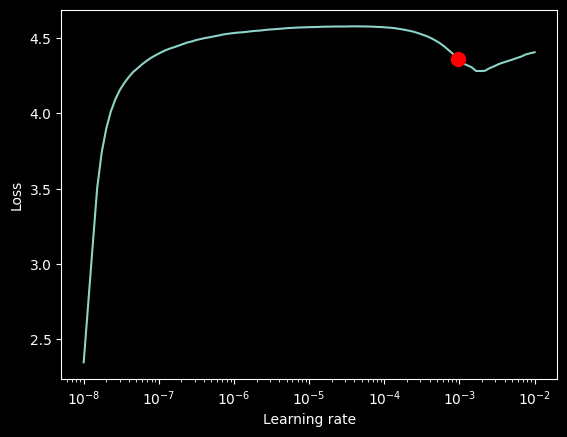

In [11]:
#| eval: false
lr_finder = tuner.lr_find(cls_task, datamodule=cls_task.lit_data, max_lr=1e-2)
print(lr_finder.results)
fig = lr_finder.plot(suggest=True)
fig.show()
new_lr = lr_finder.suggestion()
new_lr, cls_task.hparams.learning_rate

In [12]:
# @patch
# def get_early_stop_callback(self: ClassificationTask, monitor='valid_loss', min_delta=0, patience=1, mode='min'):

In [13]:
#| eval: false
# size = cls_task.cls_model.image_preprocessor.size['height']
# cls_task.example_input_array = torch.Tensor(1, cls_task.cls_model.backbone.config.num_channels, size, size)
cls_task.example_input_array.shape

torch.Size([1, 3, 224, 224])

In [ ]:
#| eval: false
from namable_classify.infra import runs_path
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelSummary
trainer = L.Trainer(default_root_dir=runs_path, enable_checkpointing=True, 
                    enable_model_summary=True, 
                    # num_sanity_val_steps=2, # 防止 val 在训了好久train才发现崩溃
                    num_sanity_val_steps=0, # 防止 val 在训了好久train才发现崩溃
                    callbacks=[
                        # EarlyStopping(monitor="val_loss", mode="min")
                        EarlyStopping(monitor="val_acc1", mode="max", check_finite=True, 
                                      patience=5, 
                                      check_on_train_epoch_end=False,  # check on validation end
                                      verbose=True),
                        ModelSummary(max_depth=3),
                               ]
                    # , fast_dev_run=True
                    # , limit_train_batches=10, 
                    # limit_val_batches=5
                    )
trainer.fit(cls_task, datamodule=cls_task.lit_data)

ModuleNotFoundError: No module named 'namable_classify.utils'

In [ ]:
#| eval: false
cls_task.cls_model.backbone.print_model_pretty()
cls_task.cls_model.backbone.training

root
├── embeddings (ViTEmbeddings) cls_token:[1, 1, 768] position_embeddings:[1, 197, 768]
│   └── patch_embeddings (ViTPatchEmbeddings)
│       └── projection (Conv2d) weight:[768, 3, 16, 16] bias:[768]
├── encoder (ViTEncoder)
│   └── layer (ModuleList)
│       └── 0-11(ViTLayer)
│           ├── attention (ViTAttention)
│           │   ├── attention (ViTSelfAttention)
│           │   │   └── query,key,value(Linear) weight:[768, 768] bias:[768]
│           │   └── output (ViTSelfOutput)
│           │       └── dense (Linear) weight:[768, 768] bias:[768]
│           ├── intermediate (ViTIntermediate)
│           │   └── dense (Linear) weight:[3072, 768] bias:[3072]
│           ├── output (ViTOutput)
│           │   └── dense (Linear) weight:[768, 3072] bias:[768]
│           └── layernorm_before,layernorm_after(LayerNorm) weight:[768] bias:[768]
├── layernorm (LayerNorm) weight:[768] bias:[768]
└── pooler (ViTPooler)
    └── dense (Linear) weight:[768, 768] bias:[768]

False

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()